# Using special token

In [1]:
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer

In [3]:
model_config =  AutoConfig.from_pretrained('klue/bert-base')
model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', config=model_config)
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [11]:
import pandas as pd
import torch

def preprocessing_dataset(dataset):
    """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_word, subject_idx, subject_type = [], [], []
    object_word, object_idx, object_type = [], [], []

    for subject_entity, object_entity in zip(dataset['subject_entity'], dataset['object_entity']):
        subject_dict = eval(subject_entity)
        object_dict = eval(object_entity)

        subject_word.append(subject_dict['word'])
        subject_idx.append((subject_dict['start_idx'], subject_dict['end_idx']))
        subject_type.append(subject_dict['type'])
        object_word.append(object_dict['word'])
        object_idx.append((object_dict['start_idx'], object_dict['end_idx']))
        object_type.append(object_dict['type'])

    out_dataset = pd.DataFrame({
        'id': dataset['id'], 
        'sentence': dataset['sentence'],
        'subject_word': subject_word,
        'subject_idx': subject_idx,
        'subject_type': subject_type,
        'object_word': object_word,
        'object_idx': object_idx,
        'object_type': object_type,
        'label': dataset['label'],
        'source': dataset['source']
    })

    return out_dataset

In [12]:
pd_dataset = pd.read_csv('../../../dataset/train/train.csv')
dataset = preprocessing_dataset(pd_dataset)

In [13]:
dataset.head()

,id,sentence,subject_word,subject_idx,subject_type,object_word,object_idx,object_type,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,"(24, 26)",ORG,조지 해리슨,"(13, 18)",PER,no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,"(19, 23)",ORG,대안신당,"(14, 17)",ORG,no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,"(21, 24)",ORG,한국프로축구연맹,"(34, 41)",ORG,org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,"(13, 17)",ORG,박정부,"(22, 24)",PER,org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,"(22, 30)",ORG,1967,"(0, 3)",DAT,no_relation,wikipedia


In [17]:
import pickle as pickle

def label_to_num(file_path, label):
    num_label = []
    with open(file_path, 'rb') as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label

In [20]:
train_dataset = dataset
train_label = label_to_num('../dict_label_to_num.pkl', train_dataset['label'].values) 
train_label[:5]

[0, 0, 20, 1, 0]

In [21]:
train_dataset.head()

,id,sentence,subject_word,subject_idx,subject_type,object_word,object_idx,object_type,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,"(24, 26)",ORG,조지 해리슨,"(13, 18)",PER,no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,"(19, 23)",ORG,대안신당,"(14, 17)",ORG,no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,"(21, 24)",ORG,한국프로축구연맹,"(34, 41)",ORG,org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,"(13, 17)",ORG,박정부,"(22, 24)",PER,org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,"(22, 30)",ORG,1967,"(0, 3)",DAT,no_relation,wikipedia


In [31]:
def tokenized_dataset(dataset, tokenizer):
    """ tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    for e01, e02 in zip(dataset['subject_word'], dataset['object_word']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
          concat_entity,
          list(dataset['sentence']),
          return_tensors="pt",
          padding=True,
          truncation=True,
          max_length=256,
          add_special_tokens=True,
          #return_token_type_ids=False,
    )
    return tokenized_sentences

In [32]:
tokenized_train = tokenized_dataset(train_dataset, tokenizer)

In [33]:
print(tokenized_train[0].tokens[:10])

['[CLS]', '비틀즈', '[SEP]', '조지', '해리', '##슨', '[SEP]', '〈', 'So', '##me']


In [36]:
train_dataset.head(1)

,id,sentence,subject_word,subject_idx,subject_type,object_word,object_idx,object_type,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,"(24, 26)",ORG,조지 해리슨,"(13, 18)",PER,no_relation,wikipedia


In [131]:
if dataset["subject_idx"][0] > dataset["object_idx"][0]:
    print(dataset["sentence"][0][:dataset["object_idx"][0][0]]
          + f'[{dataset["object_type"][0]}]' + dataset['object_word'][0] + f'[/{dataset["object_type"][0]}]'
          + dataset["sentence"][0][dataset["object_idx"][0][1]+1:dataset["subject_idx"][0][0]]
          + f'[{dataset["subject_type"][0]}]' + dataset['subject_word'][0] + f'[/{dataset["subject_type"][0]}]'
          + dataset["sentence"][0][dataset["subject_idx"][0][1]+1:]
         )


〈Something〉는 [PER]조지 해리슨[/PER]이 쓰고 [ORG]비틀즈[/ORG]가 1969년 앨범 《Abbey Road》에 담은 노래다.


## Typed entity marker

In [116]:
def tokenized_dataset_custom(dataset, tokenizer):
    sentence_list = []
    seperate_token = '[SEP]'
    for s_word, s_type, s_idx, o_word, o_type, o_idx, sentence in zip(dataset['subject_word'], dataset['subject_type'], dataset['subject_idx'],
                                                                        dataset['object_word'], dataset['object_type'], dataset['object_idx'], dataset['sentence']):
        # s_idx = eval(s_idx)
        # o_idx = eval(o_idx)
        if s_idx > o_idx:
            sentence_list.append(sentence[:o_idx[0]] + f'<O:{o_type}>' + o_word + f'</O:{o_type}>' + sentence[o_idx[1]+1:s_idx[0]] \
                                 + seperate_token + f'<S:{s_type}>' + s_word + f'</S:{s_type}>' + sentence[s_idx[1]+1:])
        else:
            sentence_list.append(sentence[:s_idx[0]] + f'<S:{s_type}>' + s_word + f'</S:{s_type}>' + sentence[s_idx[1]+1:o_idx[0]] \
                                 + seperate_token + f'<O:{o_type}>' + o_word + f'</O:{o_type}>' + sentence[o_idx[1]+1:])


    tokenized_sentences = tokenizer(
        sentence_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
        #return_token_type_ids=False, # 문장 id
    )
    
    return tokenized_sentences

In [117]:
tokenized_train = tokenized_dataset_custom(dataset, tokenizer)
tokenized_train

{'input_ids': tensor([[    2,   168, 30985,  ...,     0,     0,     0],
        [    2,  6409,  2052,  ...,     0,     0,     0],
        [    2,    47, 17665,  ...,     0,     0,     0],
        ...,
        [    2,    32,    55,  ...,     0,     0,     0],
        [    2, 15724,    16,  ...,     0,     0,     0],
        [    2,    32,    55,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [118]:
special_tokens_dict = {'additional_special_tokens': ['<S:PER>','<S:ORG>','<S:POH>','<S:DAT>','<S:LOC>','<S:NOH>','<O:PER>','<O:ORG>','<O:POH>','<O:DAT>','<O:LOC>','<O:NOH>','</S:PER>','</S:ORG>','</S:POH>','</S:DAT>','</S:LOC>','</S:NOH>','</O:PER>','</O:ORG>','</O:POH>','</O:DAT>','</O:LOC>','</O:NOH>']}

tokenizer.add_special_tokens(special_tokens_dict)

0

In [119]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['<S:PER>', '<S:ORG>', '<S:POH>', '<S:DAT>', '<S:LOC>', '<S:NOH>', '<O:PER>', '<O:ORG>', '<O:POH>', '<O:DAT>', '<O:LOC>', '<O:NOH>', '</S:PER>', '</S:ORG>', '</S:POH>', '</S:DAT>', '</S:LOC>', '</S:NOH>', '</O:PER>', '</O:ORG>', '</O:POH>', '</O:DAT>', '</O:LOC>', '</O:NOH>']})

In [130]:
print(tokenizer.encode(train_dataset.sentence.iloc[0]))
#print(tokenizer.encode(train_dataset.sentence.iloc[0]).token_type_ids)
tokenizer.decode(tokenizer.encode(train_dataset.sentence.iloc[0]))

[2, 168, 30985, 14451, 7088, 4586, 169, 793, 8373, 14113, 2234, 2052, 1363, 2088, 29830, 2116, 14879, 2440, 6711, 170, 21406, 26713, 2076, 25145, 5749, 171, 1421, 818, 2073, 4388, 2062, 18, 3]


'[CLS] 〈 Something 〉 는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《 Abbey Road 》 에 담은 노래다. [SEP]'

In [77]:
class RE_Dataset(torch.utils.data.Dataset):
    """ Dataset 구성을 위한 class."""
    def __init__(self, pair_dataset, labels):
        self.pair_dataset = pair_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [78]:
RE_train_dataset = RE_Dataset(tokenized_train, train_label)

In [79]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32005, 768)

## Typed entity marker Punctuation

In [146]:
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

In [154]:
def tokenized_dataset_custom(dataset, tokenizer):
    sentence_list = []

    for s_word, s_type, s_idx, o_word, o_type, o_idx, sentence in zip(dataset['subject_word'], dataset['subject_type'], dataset['subject_idx'],
                                                                        dataset['object_word'], dataset['object_type'], dataset['object_idx'], dataset['sentence']):
        # s_idx = eval(s_idx)
        # o_idx = eval(o_idx)
        if s_idx > o_idx:
            sentence_list.append(sentence[:o_idx[0]] + f' # ∧ [{o_type}] ∧ {o_word} # ' + sentence[o_idx[1]+1:s_idx[0]] \
                                 + f' @ * {s_type} * {s_word} @ ' + sentence[s_idx[1]+1:])
        else:
            sentence_list.append(sentence[:s_idx[0]] + f' @ * {s_type} * {s_word} @ ' + sentence[s_idx[1]+1:o_idx[0]] \
                                 + f' # ∧ {o_type} ∧ {o_word} # ' + sentence[o_idx[1]+1:])

    print(sentence_list[0])
    tokenized_sentences = tokenizer(
        sentence_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
        #return_token_type_ids=False, # 문장 id
    )
    
    return tokenized_sentences

In [155]:
special_tokens_dict = {'additional_special_tokens': ['[PER]', 'ORG', 'LOC', 'POH', 'NOH', 'DAT']}

tokenizer.add_special_tokens(special_tokens_dict)
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['[PER]', 'ORG', 'LOC', 'POH', 'NOH', 'DAT']})

In [157]:
tokenizer.decode(tokenized_dataset_custom(dataset.head(1), tokenizer).input_ids[0])

〈Something〉는  # ∧ [PER] ∧ 조지 해리슨 # 이 쓰고  @ * ORG * 비틀즈 @ 가 1969년 앨범 《Abbey Road》에 담은 노래다.


'[CLS] 〈 Something 〉 는 # [UNK] [ PER ] [UNK] 조지 해리슨 # 이 쓰고 @ * ORG * 비틀즈 @ 가 1969년 앨범 《 Abbey Road 》 에 담은 노래다. [SEP]'

## Dataset 정제하기

In [80]:
import pandas as pd

pd_dataset = pd.read_csv('../../../dataset/train/train.csv')
dataset = preprocessing_dataset(pd_dataset)

In [81]:
dataset.head()

,id,sentence,subject_word,subject_idx,subject_type,object_word,object_idx,object_type,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,"(24, 26)",ORG,조지 해리슨,"(13, 18)",PER,no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,"(19, 23)",ORG,대안신당,"(14, 17)",ORG,no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,"(21, 24)",ORG,한국프로축구연맹,"(34, 41)",ORG,org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,"(13, 17)",ORG,박정부,"(22, 24)",PER,org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,"(22, 30)",ORG,1967,"(0, 3)",DAT,no_relation,wikipedia


In [86]:
pd.set_option('display.max.colwidth', 2000)
test_data = pd.read_csv('../../../dataset/test/test_data.csv')
test_data.subject_entity.head()

0         {'word': 'MBC', 'start_idx': 7, 'end_idx': 9, 'type': 'ORG'}
1    {'word': '프린세스 프링', 'start_idx': 7, 'end_idx': 13, 'type': 'PER'}
2      {'word': '경찰', 'start_idx': 121, 'end_idx': 122, 'type': 'ORG'}
3        {'word': '세조', 'start_idx': 78, 'end_idx': 79, 'type': 'PER'}
4         {'word': '민주당', 'start_idx': 3, 'end_idx': 5, 'type': 'ORG'}
Name: subject_entity, dtype: object

In [87]:
test_data.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,"{'word': 'MBC', 'start_idx': 7, 'end_idx': 9, 'type': 'ORG'}","{'word': '탐사기획 스트레이트', 'start_idx': 12, 'end_idx': 21, 'type': 'ORG'}",100,wikitree
1,1,"사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이란 뜻으로 탄생, 부활, 청춘 등 여러 가지 의미를 담아 생일왕국의 공주님의 이름이 되었다.","{'word': '프린세스 프링', 'start_idx': 7, 'end_idx': 13, 'type': 'PER'}","{'word': '공주', 'start_idx': 84, 'end_idx': 85, 'type': 'POH'}",100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으로 편성될 예정이었는데 제작비 문제 때문에 연출자 고석만 PD(당시 단막극 팀장)가 MBC에 지원을 요청했지만 거절당한 데다 MBC가 경찰과의 관계 약화를 염려하여 제작을 달갑지 않게 여겼고 이 과정에서 연출자가 1995년 3월 29일 MBC에 사표를 제출한 후 프리랜서를 선언하여 편성이 무산됐으며 고석만 PD는 의 제작과 관련한 MBC와의 마찰 외에도 1994년 10월 ""평프로듀서로 일하고 싶다""며 당시 맡고 있던 단막극 책임PD(종합병원 전원일기 등등) 보직 사퇴의사를 밝혔지만 MBC 측의 반대로 무산되자 프리랜서를 선언했다.","{'word': '경찰', 'start_idx': 121, 'end_idx': 122, 'type': 'ORG'}","{'word': '1995년', 'start_idx': 31, 'end_idx': 35, 'type': 'DAT'}",100,wikipedia
3,3,"정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하였는데, 김질의 죄는 만번 죽어 마땅합니다.'라고 하니, 세조가 특별히 김질을 사면하였다.","{'word': '세조', 'start_idx': 78, 'end_idx': 79, 'type': 'PER'}","{'word': '정창손', 'start_idx': 0, 'end_idx': 2, 'type': 'PER'}",100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지 않느냐""고 따졌다.","{'word': '민주당', 'start_idx': 3, 'end_idx': 5, 'type': 'ORG'}","{'word': '권영진', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",100,wikitree


In [88]:
label_check = 'per:children'

<AxesSubplot:>

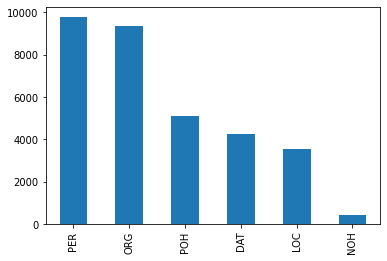

In [90]:
dataset.object_type.value_counts().plot(kind="bar")

In [108]:
temp_csv = pd.read_csv('../../../dataset/train/train_dataset.csv')
temp_add_csv = pd.read_csv('../../../dataset/train/additional_dataset.csv')